# Mạng nơ-ron

Mạng nơ-ron được xây dựng dựa trên ý tưởng mô phỏng lại cách hoạt động của bộ não con người. 
- Mỗi nơ-ron nhận tín hiệu truyền vào, xử lý tín hiệu và tiếp tục gửi tín hiệu đến nơ-ron kế tiếp cho đến khi tín hiệu được xử lý hoàn tất (forward). 
- Sau đó, thông tin về việc xử lý tín hiệu được truyền ngược lại thông qua một cung phản xạ đến nơ-ron phát tín hiệu ban đầu (backward).

Một mạng nơ-ron bắt buộc phải có một tầng đầu vào và một tầng đầu ra. Các tầng ẩn có thể có hoặc không.

<img src="multi_layers.png" style="width:50%; text-align:center">

Trên đây là một hình vẽ mô tả mạng nơ-ron đầy đủ với tầng đầu vào (`input`), 2 tầng ẩn (`hidden layer`) và tầng đầu ra (`output`). `W` là các trọng số dùng để biến đổi tín hiệu truyền từ nơ-ron này sang nơ-ron khác (hay từ lớp này sang lớp khác).

Trong bài học này, chúng ta sẽ làm quen với cách xây dựng một mô hình mạng nơ-ron nhân tạo sử dụng thư viện **Keras**.

# Import dữ liệu

In [2]:
# Import một số thư viện cần thiết.
import random
import numpy as np
import matplotlib.pyplot as plt
import keras

# Sử dụng một mẹo nhỏ để vẽ hình trên cùng một dòng thay vì mở cửa sổ mới
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # đặt kích thước mặc định cho hình
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Một mẹo nhỏ để notebook tự load lại các module bên ngoài;
# xem thêm tại http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
# Tải dữ liệu Cifar10 từ Keras và chia thành dữ liệu huấn luyện và kiểm tra.
from keras.datasets import cifar10

# Dũ liệu CIFAR10 gồm 50,000 ảnh màu kích thước 32x32 để huấn luyện, gồm 10 chuyên mục, và 10,000 ảnh kiểm tra.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


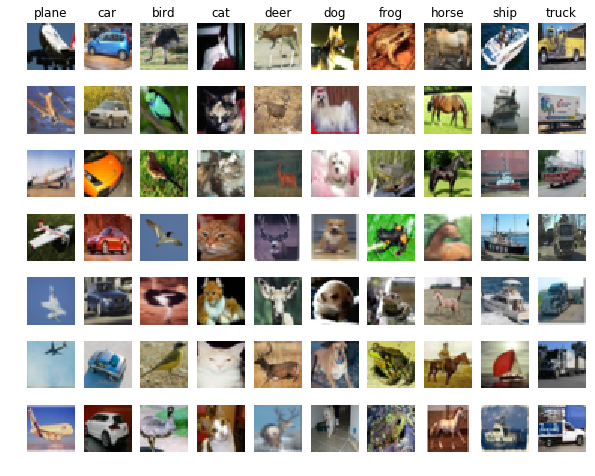

In [4]:
# Hiển thị một số ảnh từ trong bộ dữ liệu.
# Với mỗi lớp, chúng ta sẽ hiển thị một số ảnh minh họa.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [19]:
# Lấy 1 phần nhỏ dữ liệu để huấn luyện hiệu quả hơn trong bài tập này
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [20]:
# # Định dạng lại hình ảnh thành các hàng
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# Xây dựng mô hình với Keras

**Keras** là một API mạng nơ-ron bậc cao, viết bằng ngôn ngữ Python và có thể chạy trên nền của `Tensorflow`, `CNTK` hay `Theano`.  `Keras` được phát triển với trọng tâm là cho phép người phát triển xây dựng những thử nghiệm nhanh chóng, đi từ ý tưởng đến kết quả với ít chậm trễ nhất.

Cấu trúc dữ liệu cốt lõi của **Keras** là mô hình, cách để tổ chức các lớp. 

Để xây dựng một mô hình trong **Keras**, ta có 2 cách:
- Xây dụng mô hình tuần tự (Sequential model) *hoặc*
- Xây dựng API chức năng (Functional API)

## Mô hình tuần tự
**Mô hình tuần tự** là loại mô hình đơn giản nhất trong **Keras**, là một ngăn xếp tuyến tính các lớp. Để xây dựng mô hình tuần tự, ta thêm lần lượt các lớp theo thứ tự vào trong mô hình.

In [21]:
# import mô hình tuần tự từ thư viện Keras
from keras.models import Sequential

# khởi tạo biến model là một ngăn xếp chứa các lớp
model = Sequential()

### Dense
**Dense** được sử dụng để cài đặt biểu thức **output = activation(dot(input, kernel) + bias)**

Trong đó:
- **activation** là hàm kích hoạt trong một nơ-ron (một lớp), được truyền qua tham số **activation**;
- **kernel** là ma trận trọng số của từng lớp;
- **bias** là véc-tơ sai số của từng lớp.

Tìm hiểu thêm về **Dense** tại [đây](https://keras.io/layers/core/#dense)

In [ ]:
# import Dense để tạo ra các lớp trong ngăn xếp model
from keras.layers import Dense

# sử dụng hàm add() để thêm lớp vào trong ngăn xếp
# Tham số:
#    - input_shape hay input_dim: thể hiện kích thước hay số chiều của dữ liệu đầu vào
#    - units: số chiều của dữ liệu tại đầu ra của lớp hiện thời
#    - activation (optional): hàm kích hoạt được sử dụng trong lớp (mặc định là hàm tuyến tính: a(x) = x)

# lấy kích thước của dữ liệu đầu vào
# input_dim: số chiều của mỗi dữ liệu
input_dim = X_train.shape[1]

# input_shape gồm số lượng dữ liệu và số chiều của mỗi dữ liệu
input_shape = X_train.shape

# lớp đầu vào có đầu ra dữ liệu là 64 và không sử dụng hàm kích hoạt
model.add(Dense(units=1024, input_dim=input_dim))


In [36]:
X_train.shape

(5000, 3072)

### Hàm kích hoạt (Activation)
**Hàm kích hoạt** được sử dụng để biến đổi tín hiệu đầu vào của một nơ-ron thành tín hiệu đầu ra phù hợp để tiếp tục truyền đi đến nơ-ron tiếp theo.

Ta có thể truyền hàm kích hoạt vào trong mô hình như một tham số của lớp **Dense** hoặc truyền riêng biệt sử dụng lớp **Activation**.

Một số hàm kích hoạt thường sử dụng trong `Keras`: `sigmoid`, `softmax`, `tanh`, `relu`, `softplus`. Tìm hiểu thêm về các hàm kích hoạt tại [đây](https://keras.io/activations/)


In [23]:
# import lớp Activation
from keras.layers import Activation

# sử dụng hàm add() để thêm lớp Activation vào mô hình 
# (trước đó tầng ẩn đã được thêm vào với hàm model.add(Dense()))
# hàm kích hoạt được sử dụng là sigmoid
model.add(Activation('sigmoid')) 

**Bài tập: ** Cài đặt thêm hai tẩng ẩn và tầng đầu ra vào mô hình với:
- Tầng thứ nhất: số chiều đầu ra là **512** và sử dụng hàm kích hoạt **tanh**;
- Tầng thứ hai: số chiều đầu ra là **128** và sử dụng hàm kích hoạt **relu**.
- Tầng đầu ra: số chiều đầu ra là **1**.

In [24]:
# Code tại đây
model.add(Dense(units=512, activation='tanh'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

### Biên dịch
Sau khi xây dựng được cấu trúc các lớp trong ngăn xếp, ta cần chỉ ra quá trình học của mô hình thông qua hàm **compile()** trước khi huấn luyện mô hình.

Hàm này nhận 3 tham số quan trọng:
- Bộ tối ưu hóa (**optimizer**). Là một chuỗi xác định bộ tối ưu hóa đã được cài đặt sẵn (chẳng hạn như `rmsprop` hay `adam`) hay một thể hiện của lớp [**Optimizer**](https://keras.io/optimizers/). 
- Hàm mất mát (**loss**). Đây là đối tượng mô hình cần cực tiểu hóa. Nó là một xâu xác định tên hàm mất mát đã được cài đặt (ví dụ `categorical_crossentropy ` hay `mse`), hoặc một đối tượng hàm, chi tiết xem tại [đây.](https://keras.io/losses/)
- Danh sách metric (**metrics**). Trong bài toán phân lớp, ta thường chọn `metrics=['accuracy']`.

Tham khảo thêm tại [đây](https://keras.io/getting-started/sequential-model-guide/#compilation)

In [37]:
# Ví dụ về việc định nghĩa quá trình học của mô hình với
# bộ tối ưu là 'rmsprop', hàm mất mát là 'categorical_crossentropy'
# và list metric là 'accuracy' 
from keras import optimizers
adam = optimizers.adam(lr=0.8)
model.compile(optimizer=adam,
              loss='hinge',
              metrics=['accuracy'])


**Bài tập:** Biên dịch lại mô hình với hàm mất mát là **hinge**, tối ưu hóa bởi **adam** và trả về danh sách metrics **accuracy**.

In [70]:
# Code tại đây
#model.compile(optimizer='adam',
#             loss='hinge',
#             metrics=['accuracy'])

### Huấn luyện mô hình
Các mô hình của **Keras** được huấn luyện trên các mảng **Numpy** của dữ liệu đầu vào và nhãn. Để huấn luyện một mô hình, cần sử dụng hàm **fit()**.

Một số tham số quan trọng của hàm **fit()**:
- **x**: Ddữ liệu huấn luyện dưới dạng mảng numpy;
- **y**: Nhãn dữ liệu tương ứng với dữ liệu huấn luyện (mảng numpy);
- **batch_size**: Số lượng dữ liệu trong mỗi lần cập nhật gradient (kiểu nguyên hoặc `None`). Giá trị mặc định là `32`.
- **epochs**: Số lượng giai đoạn để huấn luyện mô hình (kiểu nguyên).

Tìm hiểu thêm về các hàm liên quan tại [đây](https://keras.io/models/sequential/)

In [38]:
# Huấn luyện mô hình dựa trên dữ liệu huấn luyện X_train, y_train
# Lặp lại quá trình học với epochs=10 và batch_size=32
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
5000/5000 [==============================] - 22s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 2/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.9896 - acc: 0.1038
Epoch 3/10
5000/5000 [==============================] - 22s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 4/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 5/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 6/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 7/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 8/10
5000/5000 [==============================] - 20s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 9/10
5000/5000 [==============================] - 21s 4ms/step - loss: 0.9896 - acc: 0.1038
Epoch 10/10
5000/5000 [==============================] - 21s 4ms/step - loss: 0.9896 - acc: 0.1038


Hàm **fit()** trả về **History** lưu lại lịch sử cập nhật của mô hình. Ta có thể vẽ lại được sự thay đổi của mô hình dựa trên thuộc tính **History.history**, nó lưu lại các giá trị hàm mất mát (`loss`) và giá trị metric tương ứng (`acc`) qua mỗi giai đoạn.

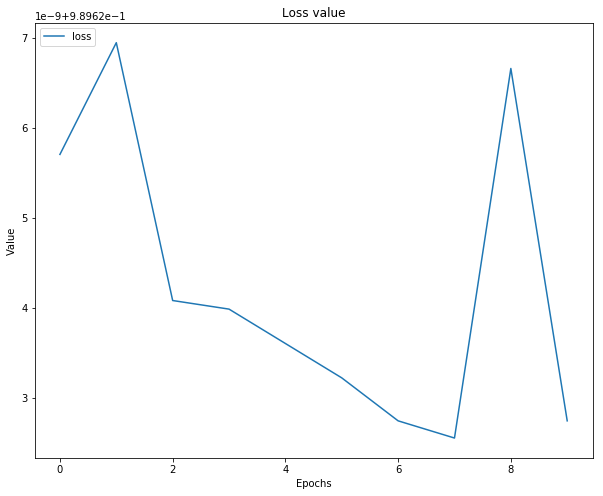

In [39]:
# Xây dựng biểu đồ thể hiện lịch sử thay đổi của mô hình qua mỗi giai đoạn
plt.plot(history.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

 
**Bài tập:** Huấn luyện lại mô hình với số epochs là **100** và batch_size bằng **64**. Sử dụng một biến để lưu lại giá trị trả về của hàm **fit()**, dựa vào đó, vẽ lại biểu đồ sự thay đổi của metric qua các giai đoạn.  

In [42]:
history_new = model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 4/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 5/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 7/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 9/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038
Epoch 10/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9896 - acc: 0.1038


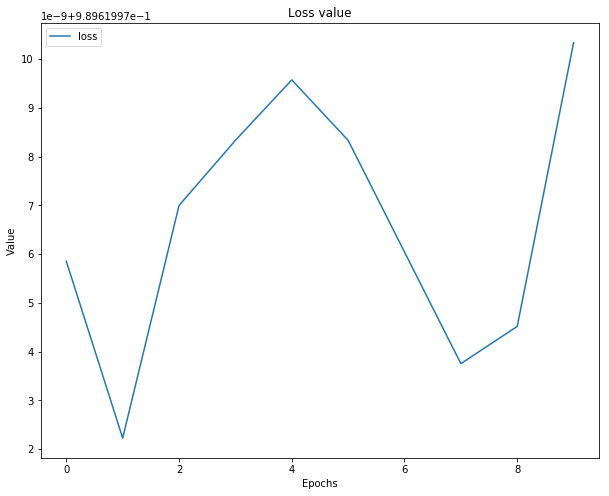

In [43]:
plt.plot(history_new.history['loss'])
plt.title("Loss value")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(['loss'], loc='upper left')
plt.show()

### Dự đoán

Sau khi huấn luyện, mô hình được đánh giá với dữ liệu kiểm tra bằng hàm **evaluate()**.

Hàm nhận 3 tham số quan trọng lần lượt là:
- **x**: Dữ liệu kiểm tra (kiểu mảng Numpy);
- **y**: Nhãn tương ứng với dữ liệu kiểm tra (kiểu mảng Numpy);
- **batch_size**: Số lượng ví dụ được dùng trong mỗi lần cập nhật gradient (kiểu nguyên). Mặc định là **32**.

Hàm trả về một mảng số thực **score** chứa giá trị hàm mất mát (**loss**) và giá trị metric (**accuracy**). Nếu mô hình không có metric, **score** là giá trị mất mát.

In [44]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

500/500 [==============================] - 1s 1ms/step
[0.98939999771118159, 0.106]


## API chức năng
**API chức năng** là lựa chọn tối ưu trong việc xây dựng mạng kết nối với mật độ cao (các lớp không liên kết tuần tự trong ngăn xếp).

Các lớp có thể đồng thời là đầu vào của nhiều lớp kế tiếp, bằng cách sử dụng đầu ra của lớp đó như một tham số truyền vào của một hàm của lớp khác.

Xây dựng một mô hình với **API chức năng** về cơ bản giống với xây dựng **mô hình tuần tự**. Điều khác nhau duy nhất là quá trình xây dựng cấu trúc các lớp.

In [45]:
# import thêm lớp Input để khởi tạo mô hình
from keras.layers import Input
from keras.models import Model

# khởi tạo một thể hiện của lớp Input
# tham số shape (kiểu tuple) là kích thước của dữ liệu đầu vào (số chiều dữ liệu)
# giá trị trả về là một tensor
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))

# mỗi thể hiện của một lớp có thể được gọi bởi một tensor
# và kết quả trả về là một tensor
# thêm một tầng ẩn gọi đến tensor inputs
x = Dense(64, activation="sigmoid")(inputs)

# ... có thể thêm nhiều tầng ẩn ở giữa ...

# tầng đầu ra của mô hình với số chiều 1
predictions = Dense(1)(x)

# Tạo ra mô hình mới bao gồm tầng đầu vào và các tầng ẩn (kết thúc bằng tensor predictions)
api_model = Model(inputs=inputs, outputs=predictions)

Phần còn lại của quá trình xây dựng **API chức năng** tương tự như **Mô hình tuần tự**.

Tham khảo thêm tại [đây](https://keras.io/getting-started/functional-api-guide/)

**Bài tập:** Tiếp tục hoàn thiện quá trình xây dụng **API chức năng** (biên dịch và huấn luyện mô hình). Sử dụng kết quả **History** trong quá trình huấn luyện để vẽ ra đồ thị thay đổi của giá trị mất mát trong các giai đoạn.

In [ ]:
# Code ở đây

### Bài tập
Xây dựng mô hình (bằng **API chức năng** hoặc **Mô hình tuần tự**) sao cho hiệu năng (`acc`) trên tập kiểm tra đạt trên 15%.

In [ ]:
# Code ở đây